In [1]:
from timeseries_ml_utils.data import DataFetcher, DataGenerator
from timeseries_ml_utils.statistics import RelativeAccuracy
from scipy.fftpack import dct, idct
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, GRU, Embedding, LSTM
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.utils import plot_model
from keras.callbacks import TensorBoard
import keras
import matplotlib.pyplot as plt
import re

Using TensorFlow backend.


In [2]:
# fetch data
data = DataFetcher(["GLD.US"], limit=450)
data.fetch_data().tail()


,GLD.US.Open,GLD.US.High,GLD.US.Low,GLD.US.Close,GLD.US.Volume
Date,,,,,
2018-11-12,114.01,114.05,113.58,113.66,7499046
2018-11-13,113.72,113.93,113.42,113.70,9309074
2018-11-14,113.53,115.06,113.46,114.64,13950218
2018-11-15,114.83,114.99,114.56,114.77,8910585
2018-11-16,115.83,115.88,115.37,115.62,8576955


In [3]:
print(len(data.get_dataframe()))
model_data = DataGenerator(data.get_dataframe(), {"^trigonometric": False, "(Open|High|Low|Close)$": True}, {"GLD.US.Close$": True}, aggregation_window_size=16)
print(model_data.batch_feature_shape)
print(model_data.batch_label_shape)
acc_callback = RelativeAccuracy(model_data)
model_data.features, model_data.labels


450


(100, 260, 224)
(100, 16)


([('GLD.US.Open', True),
  ('GLD.US.High', True),
  ('GLD.US.Low', True),
  ('GLD.US.Close', True),
  ('trigonometric_time.cos_dow', False),
  ('trigonometric_time.sin_dow', False),
  ('trigonometric_time.cos_woy', False),
  ('trigonometric_time.sin_woy', False),
  ('trigonometric_time.cos_doy', False),
  ('trigonometric_time.sin_doy', False),
  ('trigonometric_time.sin_yer', False),
  ('trigonometric_time.cos_yer', False),
  ('trigonometric_time.sin_dec', False),
  ('trigonometric_time.cos_dec', False)],
 [('GLD.US.Close', True)])

In [4]:
model = Sequential()
model.add(LSTM(model_data.batch_label_shape[-1],
               name="LSTM-Layer-1",
               batch_input_shape=model_data.batch_feature_shape,
               activation='tanh',
               dropout=0,
               recurrent_dropout=0,
               stateful=True,
               return_sequences=model_data.return_sequences))

model.compile("Adam", loss="mse")
print(model.layers[0].get_weights()[0][0])
model.save("/tmp/keras-foo-1.h5")

[-8.46408904e-02  9.06054825e-02 -8.77263099e-02 -9.01478678e-02
  2.53351182e-02  6.19910359e-02  1.17081285e-01 -6.61904588e-02
  1.04809076e-01 -1.27218321e-01  1.39265567e-01 -3.55124548e-02
  3.64791453e-02  1.34711057e-01  4.82980311e-02 -6.92014396e-02
 -9.70360637e-03  2.52812356e-02 -1.25974819e-01  1.03378192e-01
 -1.02290750e-01 -2.36506835e-02  1.39044374e-01  1.25860661e-01
 -1.15561992e-01  1.18726969e-01 -7.11169913e-02 -8.94464999e-02
 -7.31655806e-02 -6.75761923e-02  9.69909430e-02  1.00638494e-01
  3.74285579e-02  6.66471124e-02  5.03189862e-03 -1.38952181e-01
  1.09759271e-01 -6.35210946e-02  9.95662212e-02  3.21266204e-02
  9.87560451e-02 -1.09963901e-01  9.47879106e-02 -1.36463344e-03
 -7.61419535e-04 -5.51483035e-02  4.65828627e-02 -7.24725425e-03
 -1.42437875e-01 -1.62983239e-02  1.39020860e-01  1.03431940e-01
 -7.70024359e-02  2.99070776e-03  2.82519460e-02 -1.18371695e-02
 -9.01396722e-02  1.38023406e-01 -1.36952400e-02  1.34843290e-02
 -7.55823180e-02 -5.59375

In [4]:
model = load_model("/tmp/keras-foo-1.h5")
hist = model.fit_generator(generator=model_data,
                           validation_data=model_data.as_test_data_generator(model),
                           epochs=1,
                           use_multiprocessing=True,
                           workers=4,
                           shuffle=False,
                           callbacks=[acc_callback, TensorBoard(log_dir='./.logs')])


Epoch 1/1


 1/60 [..............................] - ETA: 4:13 - loss: 0.0668

/home/kic/sources/github/python/timeseries_ml_utils/timeseries_ml_utils/statistics.py:12: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  prediction_distance = fastdtw(x1, y1)[0]
/home/kic/sources/github/python/timeseries_ml_utils/venv/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.992794). Check your callbacks.
  % delta_t_median)



 [0.83629106 0.84311689 0.84994272 0.85676855 0.86359438 0.87042021
 0.87724604 0.88407187 0.8908977  0.89772353 0.90454936] 



 2/60 [>.............................] - ETA: 3:10 - loss: 0.0591

/home/kic/sources/github/python/timeseries_ml_utils/venv/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.996811). Check your callbacks.
  % delta_t_median)


 3/60 [>.............................] - ETA: 2:10 - loss: 0.0527

 4/60 [=>............................] - ETA: 1:41 - loss: 0.0473

 5/60 [=>............................] - ETA: 1:23 - loss: 0.0429

 6/60 [==>...........................] - ETA: 1:11 - loss: 0.0391

 7/60 [==>...........................] - ETA: 1:02 - loss: 0.0358

 8/60 [===>..........................] - ETA: 56s - loss: 0.0329 

 9/60 [===>..........................] - ETA: 51s - loss: 0.0303

10/60 [====>.........................] - ETA: 46s - loss: 0.0280

11/60 [====>.........................] - ETA: 43s - loss: 0.0259

12/60 [=====>........................] - ETA: 40s - loss: 0.0241

13/60 [=====>........................] - ETA: 37s - loss: 0.0225

14/60 [======>.......................] - ETA: 35s - loss: 0.0210

15/60 [======>.......................] - ETA: 33s - loss: 0.0198

16/60 [=======>......................] - ETA: 31s - loss: 0.0187

17/60 [=======>......................] - ETA: 30s - loss: 0.0177

18/60 [========>.....................] - ETA: 28s - loss: 0.0168

19/60 [========>.....................] - ETA: 27s - loss: 0.0160

20/60 [=========>....................] - ETA: 25s - loss: 0.0152

21/60 [=========>....................] - ETA: 24s - loss: 0.0146

22/60 [==========>...................] - ETA: 23s - loss: 0.0140

23/60 [==========>...................] - ETA: 22s - loss: 0.0134

24/60 [===========>..................] - ETA: 21s - loss: 0.0129

25/60 [===========>..................] - ETA: 20s - loss: 0.0124

26/60 [============>.................] - ETA: 19s - loss: 0.0120

27/60 [============>.................] - ETA: 18s - loss: 0.0115

28/60 [=============>................] - ETA: 18s - loss: 0.0112

29/60 [=============>................] - ETA: 17s - loss: 0.0108

30/60 [==============>...............] - ETA: 16s - loss: 0.0105

31/60 [==============>...............] - ETA: 15s - loss: 0.0101

32/60 [===============>..............] - ETA: 15s - loss: 0.0098

33/60 [===============>..............] - ETA: 14s - loss: 0.0096

34/60 [================>.............] - ETA: 13s - loss: 0.0093

35/60 [================>.............] - ETA: 13s - loss: 0.0091

36/60 [=================>............] - ETA: 12s - loss: 0.0088

37/60 [=================>............] - ETA: 11s - loss: 0.0086

38/60 [==================>...........] - ETA: 11s - loss: 0.0084

39/60 [==================>...........] - ETA: 10s - loss: 0.0082

40/60 [===================>..........] - ETA: 10s - loss: 0.0080

41/60 [===================>..........] - ETA: 9s - loss: 0.0078 

42/60 [====================>.........] - ETA: 8s - loss: 0.0076

43/60 [====================>.........] - ETA: 8s - loss: 0.0075

44/60 [=====================>........] - ETA: 7s - loss: 0.0073

45/60 [=====================>........] - ETA: 7s - loss: 0.0072

46/60 [======================>.......] - ETA: 6s - loss: 0.0070

47/60 [======================>.......] - ETA: 6s - loss: 0.0069

48/60 [=======================>......] - ETA: 5s - loss: 0.0068

49/60 [=======================>......] - ETA: 5s - loss: 0.0066

50/60 [========================>.....] - ETA: 4s - loss: 0.0065

51/60 [========================>.....] - ETA: 4s - loss: 0.0064


 [0.96196163 0.96534974 0.96873786 0.97212597 0.97551408 0.9789022
 0.98229031 0.98567843 0.98906654 0.99245466 0.99584277] 

52/60 [=========================>....] - ETA: 3s - loss: 0.0063

53/60 [=========================>....] - ETA: 3s - loss: 0.0062

54/60 [==========================>...] - ETA: 2s - loss: 0.0061

55/60 [==========================>...] - ETA: 2s - loss: 0.0060

56/60 [===========================>..] - ETA: 1s - loss: 0.0059

57/60 [===========================>..] - ETA: 1s - loss: 0.0058

58/60 [============================>.] - ETA: 0s - loss: 0.0057

59/60 [============================>.] - ETA: 0s - loss: 0.0056

60/60 [==============================] - 31s 521ms/step - loss: 0.0056 - val_loss: 0.0015



 [0.96364447 0.96685023 0.97005599 0.97326175 0.97646751 0.97967327
 0.98287903 0.98608479 0.98929055 0.99249631 0.99570207] 



0.9636    | #
0.9669    | 
0.9701    | ######
0.9733    | ######
0.9765    | ######
0.9797    | ############
0.9829    | #########
0.9861    | ###############
0.9893    | ##################################################
0.9925    | ################################################


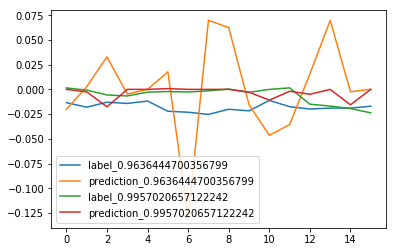

In [5]:
import pandas as pd
df = pd.DataFrame(acc_callback.worst_sample)
df.plot()